# シュレッダー復元問題の定式化

## ネットワーク定式化

### 定数とインデックス

- $R$: 縦方向の分割数
- $C$: 横方向の分割数
- $N$: 紙片の総数, $R \times C$
- $S^{x}_{ab}$: 紙片 $a$ の右に紙片 $b$ が置かれている場合の類似度
- $S^{y}_{ab}$: 紙片 $a$ の下に紙片 $b$ が置かれている場合の類似度
- $a,b \in [1,\dots,N]$: 紙片を表すインデックス

### 変数

- $x_{ab}$: 紙片 $a$ の右に紙片 $b$ が置かれている場合は $1$ となるフラグ
- $y_{ab}$: 紙片 $a$ の下に紙片 $b$ が置かれている場合は $1$ となるフラグ
- $u^{x}_{a}$: 横方向のポテンシャル
- $u^{y}_{a}$: 縦方向のポテンシャル

### 目的関数

$$
\max \sum_{ab}S^{x}_{ab}x_{ab} + \sum_{ab}S^{y}_{ab}x_{ab}
$$

### 制約条件

- $\sum_{b} x_{ab} = 1$
- $\sum_{b} x_{ba} = 1$
- $\sum_{b} y_{ab} = 1$
- $\sum_{b} y_{ba} = 1$
- $u^{x}_{a} + 1 - (N-1)(1 - x_{ab}) \leq u^{x}_{b}$
- $u^{y}_{a} + 1 - (N-1)(1 - y_{ab}) \leq u^{y}_{b}$
- $u^{x}_{a} - (N-1)(1 - y_{ab}) \leq u^{x}_{b}$
- $u^{y}_{a} - (N-1)(1 - x_{ab}) \leq u^{y}_{b}$



In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pulp

In [2]:
def load_data(path):
    with open(path, 'rb') as i_:
        return pickle.load(i_)

data = load_data('../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_4_50.pkl')

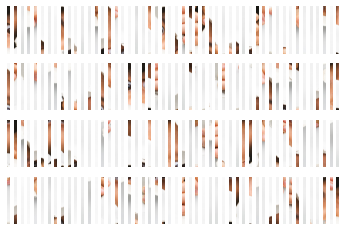

In [3]:
def show(images, rows, cols):
    fig = plt.figure()
    for i, image in enumerate(images):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.axis('off')
        ax.imshow(image)
    fig.show()

show(data.images, data.rows, data.cols)

In [4]:
def sim_x(left, right):
    shape = np.min((left.shape, right.shape), axis=0)
    return (left[:shape[0], -1] == right[:shape[0], 0]).sum()

def sim_y(up, down):
    shape = np.min((up.shape, down.shape), axis=0)
    return (up[-1, :shape[1]] == down[0, :shape[1]]).sum()

print(sim_x(data.images[0], data.images[1]))
print(sim_y(data.images[0], data.images[1]))

10
0


In [11]:
def build_model(data):
    model = pulp.LpProblem(sense=pulp.LpMaximize)
    x = np.array(pulp.LpVariable.matrix(
        'x',
        (range(data.size + 1), range(data.size + 1)),
        cat=pulp.LpBinary
    ))
    y = np.array(pulp.LpVariable.matrix(
        'y',
        (range(data.size + 1), range(data.size + 1)),
        cat=pulp.LpBinary
    ))
    ux = np.array(pulp.LpVariable.matrix(
        'ux',
        (range(data.size),),
        lowBound=1.0,
        upBound=data.cols,
        cat=pulp.LpContinuous
    ))
    uy = np.array(pulp.LpVariable.matrix(
        'uy',
        (range(data.size),),
        lowBound=1.0,
        upBound=data.rows,
        cat=pulp.LpContinuous
    ))
    for a in range(data.size + 1):
        x[a, a].upBound = 0
        x[a, a].lowBound = 0
        y[a, a].upBound = 0
        y[a, a].lowBound = 0

    model.setObjective(pulp.lpSum(
            sim_x(data.images[a], data.images[b])*x[a, b]
            for a in range(data.size)
            for b in range(data.size)
            if a != b
        ) + pulp.lpSum(
            sim_y(data.images[a], data.images[b])*y[a, b]
            for a in range(data.size)
            for b in range(data.size)
            if a != b
        )
    )

    for a in range(data.size):
        model.addConstraint(pulp.lpSum(x[a]) == 1)
        model.addConstraint(pulp.lpSum(x[:, a]) == 1)
        model.addConstraint(pulp.lpSum(y[a]) == 1)
        model.addConstraint(pulp.lpSum(y[:, a]) == 1)
    model.addConstraint(pulp.lpSum(x[-1]) == data.rows)
    model.addConstraint(pulp.lpSum(x[:-1, -1]) == data.rows)
    model.addConstraint(pulp.lpSum(y[-1]) == data.cols)
    model.addConstraint(pulp.lpSum(y[:, -1]) == data.cols)


    for a in range(data.size):
        for b in range(data.size):
            if a != b:
                model.addConstraint(
                    ux[a] + 1 - data.cols*(1 - x[a, b]) <= ux[b]
                )
                model.addConstraint(
                    ux[a] - data.cols*(1 - y[a, b] - y[b, a]) <= ux[b]
                )
                model.addConstraint(
                    uy[a] + 1 - data.rows*(1 - y[a, b]) <= uy[b]
                )
                model.addConstraint(
                    uy[a] - data.rows*(1 - x[a, b] - x[b, a]) <= uy[b]
                )
                model.addConstraint(
                    x[a, b] + x[b, a] <= 1
                )
                model.addConstraint(
                    y[a, b] + y[b, a] <= 1
                )
                model.addConstraint(
                    x[a, b] + y[a, b] <= 1
                )
                model.addConstraint(
                    x[a, b] + y[b, a] <= 1
                )
    return model, x, y, ux, uy

model, x, y, ux, uy = build_model(data)

In [12]:
#solver = pulp.PULP_CBC_CMD(timeLimit=5*60*4, threads=8)

solver = pulp.GUROBI_CMD()

# %time model.solve(solver)
model.writeMPS('4_50.mps')

[ux_0,
 ux_1,
 ux_10,
 ux_100,
 ux_101,
 ux_102,
 ux_103,
 ux_104,
 ux_105,
 ux_106,
 ux_107,
 ux_108,
 ux_109,
 ux_11,
 ux_110,
 ux_111,
 ux_112,
 ux_113,
 ux_114,
 ux_115,
 ux_116,
 ux_117,
 ux_118,
 ux_119,
 ux_12,
 ux_120,
 ux_121,
 ux_122,
 ux_123,
 ux_124,
 ux_125,
 ux_126,
 ux_127,
 ux_128,
 ux_129,
 ux_13,
 ux_130,
 ux_131,
 ux_132,
 ux_133,
 ux_134,
 ux_135,
 ux_136,
 ux_137,
 ux_138,
 ux_139,
 ux_14,
 ux_140,
 ux_141,
 ux_142,
 ux_143,
 ux_144,
 ux_145,
 ux_146,
 ux_147,
 ux_148,
 ux_149,
 ux_15,
 ux_150,
 ux_151,
 ux_152,
 ux_153,
 ux_154,
 ux_155,
 ux_156,
 ux_157,
 ux_158,
 ux_159,
 ux_16,
 ux_160,
 ux_161,
 ux_162,
 ux_163,
 ux_164,
 ux_165,
 ux_166,
 ux_167,
 ux_168,
 ux_169,
 ux_17,
 ux_170,
 ux_171,
 ux_172,
 ux_173,
 ux_174,
 ux_175,
 ux_176,
 ux_177,
 ux_178,
 ux_179,
 ux_18,
 ux_180,
 ux_181,
 ux_182,
 ux_183,
 ux_184,
 ux_185,
 ux_186,
 ux_187,
 ux_188,
 ux_189,
 ux_19,
 ux_190,
 ux_191,
 ux_192,
 ux_193,
 ux_194,
 ux_195,
 ux_196,
 ux_197,
 ux_198,
 ux_199,
 ux_2,

In [ ]:
values = np.vectorize(lambda x: x.value())

pos = values([uy - 1, ux]).T.tolist()
show(
    [data.images[_] for _ in sorted(range(data.size), key=lambda x: pos[x])],
    data.rows,
    data.cols
)
#print(model.objective.value())

In [145]:
print('left to right')
for a in range(data.size + 1):
    for b in np.where(values(x[a]))[0]:
        u = (
            values(ux[b]) if b < data.size else -1,
            values(uy[b]) if b < data.size else -1
        )
        print(f'{a} -> {b}({u})')
print('up to down')
for a in range(data.size + 1):
    for b in np.where(values(y[a]))[0]:
        print(f'{a} | {b}')


left to right
0 -> 38((array(5.), array(3.)))
1 -> 29((array(8.), array(2.)))
2 -> 17((array(8.), array(4.)))
3 -> 13((array(4.), array(4.)))
4 -> 20((array(3.), array(2.)))
5 -> 31((array(10.), array(1.)))
6 -> 1((array(7.), array(2.)))
7 -> 14((array(9.), array(3.)))
8 -> 24((array(3.), array(1.)))
9 -> 5((array(9.), array(1.)))
10 -> 11((array(5.), array(1.)))
11 -> 18((array(6.), array(1.)))
12 -> 8((array(2.), array(1.)))
13 -> 36((array(5.), array(4.)))
14 -> 30((array(10.), array(3.)))
15 -> 6((array(6.), array(2.)))
16 -> 3((array(3.), array(4.)))
17 -> 22((array(9.), array(4.)))
18 -> 35((array(7.), array(1.)))
19 -> 2((array(7.), array(4.)))
20 -> 26((array(4.), array(2.)))
21 -> 25((array(7.), array(3.)))
22 -> 28((array(10.), array(4.)))
23 -> 37((array(10.), array(2.)))
24 -> 10((array(4.), array(1.)))
25 -> 7((array(8.), array(3.)))
26 -> 15((array(5.), array(2.)))
27 -> 39((array(2.), array(3.)))
28 -> 40((-1, -1))
29 -> 23((array(9.), array(2.)))
30 -> 40((-1, -1))
31 -

In [12]:
for i in range(data.rows):
    print(f'row: {i}')
    print(values(ux)[values(uy) == i + 1])

row: 0
[48. 44. 16.  4. 12.  2. 39. 46. 26.  1. 10. 41. 11. 40.  6.  1. 37. 28.
 24. 30.  9. 42. 13. 47. 35. 36. 20. 25. 17.  3. 14. 15. 43. 38. 18. 45.
  5. 27.  7. 22. 19. 33. 34. 23.  8. 21. 49.]
row: 1
[33. 37. 43. 39.  9. 23. 50. 32. 42. 27. 47. 26. 18.  3. 49. 30. 45.  4.
  6. 44. 48. 21. 46. 36. 41. 10. 31. 12. 38. 29. 19. 40. 13. 34. 24. 14.
 50.  5. 11. 16.  2. 22. 28. 20. 35.  8. 15. 25. 17.  7.]


In [19]:
sorted(zip(np.array(values(uy)).astype(int), values(ux)))

[(1, 1.0),
 (1, 1.0),
 (1, 1.9999999999999574),
 (1, 2.9999999999998934),
 (1, 3.9999999999998934),
 (1, 4.999999999999787),
 (1, 5.999999999999723),
 (1, 6.99999999999968),
 (1, 7.999999999999652),
 (1, 8.99999999999961),
 (1, 9.999999999999545),
 (1, 10.999999999999517),
 (1, 11.999999999999488),
 (1, 12.999999999999453),
 (1, 13.999999999999396),
 (1, 14.999999999999346),
 (1, 15.99999999999929),
 (1, 16.99999999999922),
 (1, 17.99999999999916),
 (1, 18.999999999999105),
 (1, 19.999999999999048),
 (1, 20.99999999999899),
 (1, 21.999999999998934),
 (1, 22.999999999998877),
 (1, 23.999999999999343),
 (1, 24.999999999999893),
 (1, 25.999999999998707),
 (1, 27.00000000000108),
 (1, 27.999999999999893),
 (1, 28.999999999999893),
 (1, 29.999999999999893),
 (1, 30.999999999999893),
 (1, 31.999999999999893),
 (1, 32.99999999999989),
 (1, 33.99999999999989),
 (1, 35.00000000000106),
 (1, 36.00000000000017),
 (1, 37.00000000000017),
 (1, 38.00000000000017),
 (1, 39.00000000000017),
 (1, 40.00

In [27]:
x[0][1].value()

0.0